### Loading Necessary Modules

In [52]:
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Loading Dataset

In [53]:
churn_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ----------------  --------------  -----  
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMe

In [54]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Cleaning Dataset, Enumerating Values

In [55]:
churn_df = churn_df.dropna()

In [56]:
churn_df['MonthlyCharges'] = churn_df['MonthlyCharges'].astype('object')

In [57]:
churn_df.TotalCharges = churn_df.TotalCharges[(churn_df.TotalCharges != '')]
#churn_df.TotalCharges.head(25)

In [58]:
# Print all possible values for the 'PaymentMethod' column
churn_df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

<AxesSubplot:>

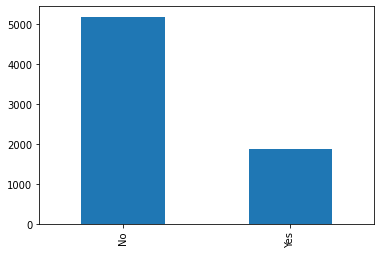

In [59]:
# Plot histogram of the 'Churn' column
churn_df.Churn.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='Churn'>

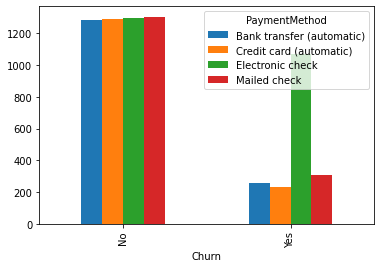

In [60]:
# Plot event count by 'Churn' and 'PaymentMethod'
churn_df.groupby(['Churn', 'PaymentMethod']).size().unstack().plot(kind='bar')

In [61]:
# Turn all columns into binary categorical features
churn_df.loc[:, 'Churn'] = churn_df.Churn.map({'Yes': 1, 'No': 0})

In [62]:
# Get total value count for column 'PaymentMethod'
churn_df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [63]:
churn_df.loc[:, 'PaymentMethod'] = churn_df.PaymentMethod.map({'Credit Card': 1, 'Bank transfer (automatic)': 1, 'Mailed check': 1, 'Electronic check': 2, 'No payment method': 0}) # 'Electronic check' is the most common payment method

<AxesSubplot:xlabel='Churn'>

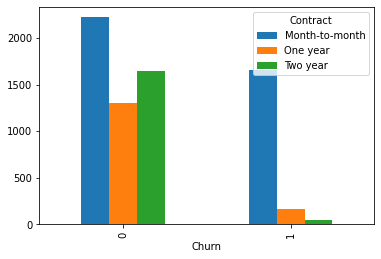

In [64]:
# Plot event count by 'Churn' and 'Contract'
churn_df.groupby(['Churn', 'Contract']).size().unstack().plot(kind='bar')

In [65]:
# Get total value count for column 'Contract'
churn_df.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [66]:
churn_df.loc[:, 'Contract'] = churn_df.Contract.map({'Month-to-month': 1, 'One year': 0, 'Two year': 0}) # month to month seems to have highest impact on Churn

<AxesSubplot:xlabel='Churn'>

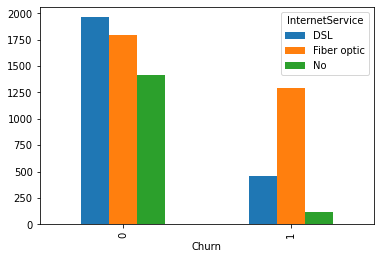

In [67]:
# Plot event count by 'Churn' and 'InternetService'
churn_df.groupby(['Churn', 'InternetService']).size().unstack().plot(kind='bar')

In [68]:
# Get total value count for column 'InternetService'
churn_df.InternetService.value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [69]:
churn_df.loc[:, 'InternetService'] = churn_df.InternetService.map({'Fiber optic': 2, 'DSL': 1, 'No': 0, 'No internet service': 0})

In [70]:
# 'MultipleLines' To numeric
churn_df.MultipleLines = churn_df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})

# All Columns value 'Yes' to 1 and 'No' to 0
churn_df = churn_df.replace({'Yes': 1, 'No': 0})

In [71]:
churn_df = churn_df.drop(['customerID'], axis=1)

In [72]:
# Maps unique values of given column to integers
mapping = {item:i for i, item in enumerate(churn_df.iloc[:, 0].unique())}
churn_df.iloc[:, 0] = churn_df.iloc[:, 0].apply(lambda x: mapping[x])
churn_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,2.0,29.85,29.85,0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,0,0,1.0,56.95,1889.5,0
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,1,1,1.0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,1,0,1,1,0,0,0,0,1.0,42.30,1840.75,0
4,0,0,0,0,2,1,0,2,0,0,0,0,0,0,1,1,2.0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,1,0,1,1,1,1,0,1,1.0,84.80,1990.5,0
7039,0,0,1,1,72,1,1,2,0,1,1,0,1,1,0,1,NaN,103.20,7362.9,0
7040,0,0,1,1,11,0,0,1,1,0,0,0,0,0,1,1,2.0,29.60,346.45,0
7041,1,1,1,0,4,1,1,2,0,0,0,0,0,0,1,1,1.0,74.40,306.6,1


In [73]:
# Remove all values in churn_df that are not numeric
churn_df = churn_df.select_dtypes(include=['number'])
churn_df = churn_df.drop(['PaymentMethod', 'MonthlyCharges'], axis=1) # Remove 'PaymentMethod' column of internal errors in column

In [74]:
churn_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ----------------  --------------  -----
 0   gender            7043 non-null   int64
 1   SeniorCitizen     7043 non-null   int64
 2   Partner           7043 non-null   int64
 3   Dependents        7043 non-null   int64
 4   tenure            7043 non-null   int64
 5   PhoneService      7043 non-null   int64
 6   MultipleLines     7043 non-null   int64
 7   InternetService   7043 non-null   int64
 8   Contract          7043 non-null   int64
 9   PaperlessBilling  7043 non-null   int64
 10  Churn             7043 non-null   int64
dtypes: int64(11)
memory usage: 605.4 KB


### Model training and set up

In [75]:
# Split data into training and testing sets
features = churn_df.iloc[:, :-1]
labels = churn_df.iloc[:, -1]

print (features.shape, '\n', labels.shape)


(7043, 10) 
 (7043,)


#### Split train test features so model is taught on 67% of data and tested on other 33% with a procedural random state

In [76]:
X=features
y=np.ravel(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X,y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  Contract  PaperlessBilling  
0                 0                1        

#### Support Vector Machine With Standart Gamma

In [77]:
from sklearn.svm import SVC
svc = SVC(gamma=0.22)
svc.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
score_svc = svc.score(X_test,y_test)
print('The accuracy of SVC Model is', str(round(score_svc*100, 2)) + '%')

The accuracy of SVC Model is 80.43%


#### Random forest with a total of 777 parameters

In [78]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=111, max_depth=7, random_state=0)
rf.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
score_rf = rf.score(X_test,y_test)
print('The accuracy of Random Forest Classifier Model is', str(round(score_rf*100, 2)) + '%')

The accuracy of Random Forest Classifier Model is 80.69%


#### Densly Connected Neural Network With 207 Total Parameters

In [79]:
# Neural Network Classifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

model = Sequential()
model.add(Dense(10, input_dim=10, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [81]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 8)                 88        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
472/472 [==============================] - 2s 975us/step - loss: 0.5220 - accuracy: 0.7365
Epoch 2/10
472/472 [==============================] - 0s 961us/step - loss: 0.4534 - accuracy: 0.7370
Epoch 3/10
472/472 [==============================] - 0s 954us/step - loss: 0.4471 - accuracy: 0.7721
Epoch 4/10
472/472 [==============================] - 0s 943us/step - loss: 0.4442 - accuracy: 0.7929
Epoch 5/10
472/472 [==============================] - 0s 952us/step - loss: 0.4422 - accuracy: 0.7976
Epoch 6/10
472/472 [==============================] - 0s 995us/step - loss: 0.4408 - accuracy: 0.7933
Epoch 7/10
472/472 [==============================] - 0s 948us/step - loss: 0.4391 - accuracy: 0.7942
Epoch 8/10
472/472 [==============================] - 0s 969us/step - loss: 0.4387 - accuracy: 0.7931
Epoch 9/10
472/472 [==============================] - 0s 961us/step - loss: 0.4374 - accuracy: 0.7950
Epoch 10/10
472/472 [==============================] - 0s 997us/step - loss: 0.437

In [30]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [31]:
scores = model.evaluate(X_test, y_test)
print(model.metrics_names)
print(scores)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

73/73 [==============================] - 0s 820us/step - loss: 0.4240 - accuracy: 0.8039
['loss', 'accuracy']
[0.42404934763908386, 0.8038709759712219]

accuracy: 80.39%


#### Confusion Matrix for the Neural Network

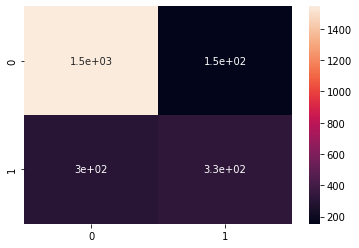

In [32]:
# Plot confusion matrix for y_test and y_pred using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

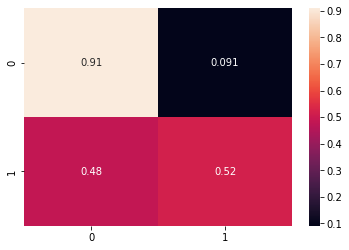

In [33]:
# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True)
plt.show()